In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import numpy as np
import pyEPR as epr
import qiskit_metal as metal
from collections import OrderedDict
import scqubits as scq
from scipy.constants import c, h, pi, hbar, e
from qiskit_metal import designs, draw, MetalGUI, Dict, Headings
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.analyses.quantization import LOManalysis, EPRanalysis
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL
from qiskit_metal.qlibrary.lumped.cap_3_interdigital import Cap3Interdigital
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry

ws_path = os.getcwd()
warnings.filterwarnings("ignore")

design = designs.DesignPlanar()
design.overwrite_enabled = True

01:44PM 17s INFO [__init__]: TransmonBuilder with system_type TRANSMON registered to QuantumSystemRegistry
01:44PM 17s INFO [__init__]: FluxoniumBuilder with system_type FLUXONIUM registered to QuantumSystemRegistry
01:44PM 17s INFO [__init__]: TLResonatorBuilder with system_type TL_RESONATOR registered to QuantumSystemRegistry
01:44PM 17s INFO [__init__]: LumpedResonatorBuilder with system_type LUMPED_RESONATOR registered to QuantumSystemRegistry


In [2]:
#constants:
phi0    = h/(2*e)
varphi0 = phi0/(2*pi)

# project target parameters
f_qList = np.around(np.linspace(5.25, 5.75, 4),2) # GHz
f_rList = f_qList + 1.8 # GHz
L_JJList = np.around(varphi0**2/((f_qList*1e9+300e6)**2/(8*300e6))/h*1e9, 2) # nH

# initial CPW readout lengths
def find_resonator_length(frequency, line_width, line_gap, N): 
    #frequency in GHz
    #line_width/line_gap in um
    #N -> 2 for lambda/2, 4 for lambda/4
    
    [lambdaG, etfSqrt, q] = guided_wavelength(frequency*10**9, line_width*10**-6,
                                              line_gap*10**-6, 750*10**-6, 200*10**-9)
    return str(lambdaG/N*10**3)+" mm"

find_resonator_length(f_rList, 10, 6, 2)

'[8.63311117 8.42983847 8.24707774 8.06138195] mm'

In [3]:
design.chips.main.size_x = '12mm'
design.chips.main.size_y = '10mm'

gui = MetalGUI(design)

design.delete_all_components()

design_span_x = 5
design_span_y = 3

half_chip_width = design_span_x / 2
half_chip_height = design_span_y / 2

connection_pads_options = dict(
    a = dict(loc_W=1, loc_H=-1),
    b = dict(loc_W=1, loc_H=1),
    c = dict(loc_W=-1, loc_H=-1)
)

connection23_pads_options = dict(
    a = dict(loc_W=1, loc_H=-1),
    c = dict(loc_W=-1, loc_H=-1)
)

transmons = []

transmons.append(TransmonPocketCL(design, 'Q1',
                      options=dict(pos_x=f'-{half_chip_width}mm',
                                   pos_y=f'{-half_chip_height}mm',
                                   connection_pads=dict(**connection_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q2',
                      options=dict(pos_x=f'0mm',
                                   pos_y=f'{half_chip_height}mm',
                                   orientation=-90,
                                   connection_pads=dict(d=dict(loc_W=-1, loc_H=1), **connection23_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q3',
                      options=dict(pos_x=f'0mm',
                                   pos_y=f'{-half_chip_height}mm',
                                   orientation=90,
                                   connection_pads=dict(d=dict(loc_W=-1, loc_H=1), **connection23_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q4',
                      options=dict(pos_x=f'{half_chip_width}mm',
                                   pos_y=f'{half_chip_height}mm',
                                   orientation=180,
                                   connection_pads=dict(**connection_pads_options))))

gui.rebuild()
gui.autoscale()

In [4]:
fillet='99.99um'
options = Dict(
    meander=Dict(
        lead_start='0.1mm',
        lead_end='0.1mm',
        asymmetry='0 um')
)

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str,
            asymmetry='0 um', start_strght='0 um', end_strght='0 um', flip=False):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        lead=Dict(
            start_straight=start_strght,
            end_straight=end_strght
        ),
        total_length=length,
    fillet = '99.9um')
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)


asym_h = 100
asym_v = 100
cpw = []

cpw.append(connect('cpw1', 'Q1', 'b', 'Q2', 'a', '8 mm', f'+{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw3', 'Q4', 'b', 'Q3', 'a', '8 mm', f'+{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw4', 'Q3', 'd', 'Q1', 'a', '8 mm', f'-{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw5', 'Q2', 'd', 'Q4', 'a', '8 mm', f'-{asym_h}um', '0.1mm', '0.1mm'))


gui.rebuild()
gui.autoscale()

In [5]:
readouts_lwc = []
control_lwc = []

offset_x = 0
offset_y = 1


#Readouts
readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R1',
                                         options = dict(
                                         pos_x = '-5mm',
                                         pos_y = f'-{half_chip_height+offset_y}mm',
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R2',
                                         options = dict(
                                         pos_x = '-1mm',
                                         pos_y = '4mm',
                                         orientation = -90,
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R3',
                                         options = dict(
                                         pos_x = '1mm',
                                         pos_y = '-4mm',
                                         orientation = 90,
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R4',
                                         options = dict(
                                         pos_x = '5mm',
                                         pos_y = f'{half_chip_height+offset_y}mm',
                                         orientation = 180,
                                         lead_length = '30um')))

#Controls
control_lwc.append(LaunchpadWirebondCoupled(design, 'CL1',
                                         options = dict(
                                         pos_x = '-5mm',
                                         pos_y = '2mm',
                                         lead_length = '30um')))

control_lwc.append(LaunchpadWirebondCoupled(design, 'CL2',
                                         options = dict(
                                         pos_x = '4mm',
                                         pos_y = '4mm',
                                         orientation = -90,
                                         lead_length = '30um')))

control_lwc.append(LaunchpadWirebondCoupled(design, 'CL3',
                                         options = dict(
                                         pos_x = '-4mm',
                                         pos_y = '-4mm',
                                         orientation = 90,
                                         lead_length = '30um')))

control_lwc.append(LaunchpadWirebondCoupled(design, 'CL4',
                                         options = dict(
                                         pos_x = '5mm',
                                         pos_y = '-2mm',
                                         orientation = 180,
                                         lead_length = '30um')))

gui.rebuild()
gui.autoscale()

In [6]:
readout_lines = []

asym_14 = 700
asym_23 = 700
options = Dict(
    lead=Dict(
        start_straight='330um',
        end_straight='0um'),
    fillet='99.99um')

readout_lines.append(connect('ol1', 'Q1', 'c', 'R1', 'tie', '8 mm', f'{asym_14}um'))

options = Dict(
    lead=Dict(
        start_straight='430um',
        end_straight='0um'),
    fillet='99.99um')
readout_lines.append(connect('ol2', 'Q2', 'c', 'R2', 'tie', '8 mm', f'{asym_23}um'))
readout_lines.append(connect('ol3', 'Q3', 'c', 'R3', 'tie', '8 mm', f'{asym_23}um'))
readout_lines.append(connect('ol4', 'Q4', 'c', 'R4', 'tie', '8 mm', f'{asym_14}um'))

gui.rebuild()
gui.autoscale()

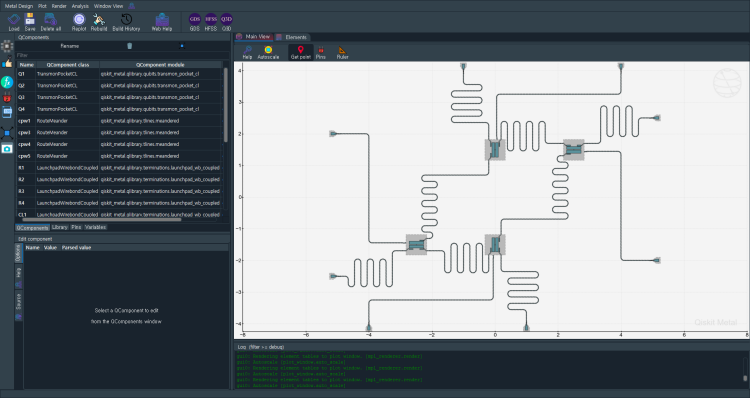

In [7]:
control_lines = []

def connectRouteAnchor(name: str,
                       component1: str, pin1: str, component2: str, pin2: str,
                       anchor_points: OrderedDict) -> RouteAnchors:

    options_line_cl = dict(
        pin_inputs = dict(start_pin = dict(component = component1, pin = pin1),
                          end_pin = dict(component = component2, pin = pin2)),
        anchors = anchor_points,
        lead = dict(start_straight = '200um',
                    end_straight = '225um'),
        fillet = fillet
    )
    
    return RouteAnchors(design, name, options_line_cl)



anchors1c = OrderedDict()
anchors1c[0] = np.array([-4, -1.42])
anchors1c[1] = np.array([-4, 2])

control_lines.append(connectRouteAnchor('line_cl1', 'Q1', 'Charge_Line', 'CL1', 'tie', anchors1c))


anchors2c = OrderedDict()
anchors2c[0] = np.array([0.08, 3.25])
anchors2c[1] = np.array([4, 3.25])

control_lines.append(connectRouteAnchor('line_cl2', 'Q2', 'Charge_Line', 'CL2', 'tie', anchors2c))

anchors3c = OrderedDict()
anchors3c[0] = np.array([-0.08, -3.25])
anchors3c[1] = np.array([-4, -3.25])

control_lines.append(connectRouteAnchor('line_cl3', 'Q3', 'Charge_Line', 'CL3', 'tie', anchors3c))

anchors4c = OrderedDict()
anchors4c[0] = np.array([4, 1.42])
anchors4c[1] = np.array([4, -2])

control_lines.append(connectRouteAnchor('line_cl4', 'Q4', 'Charge_Line', 'CL4', 'tie', anchors4c))

gui.rebuild()
gui.autoscale()
gui.screenshot(name="full_design.png")

In [8]:
# constants:
phi0    = h/(2*e)
varphi0 = phi0/(2*pi)

# project target parameters
f_qList = np.around(np.linspace(5.25, 5.75, 4),2) # GHz
f_rList = f_qList + 1.8 # GHz
L_JJList = np.around(varphi0**2/((f_qList*1e9+300e6)**2/(8*300e6))/h*1e9, 2) # nH

# initial CPW readout lengths
def find_resonator_length(frequency, line_width, line_gap, N): 
    #frequency in GHz
    #line_width/line_gap in um
    #N -> 2 for lambda/2, 4 for lambda/4
    
    [lambdaG, etfSqrt, q] = guided_wavelength(frequency*10**9, line_width*10**-6,
                                              line_gap*10**-6, 750*10**-6, 200*10**-9)
    return str(lambdaG/N*10**3)+" mm"

find_resonator_length(f_rList, 10, 6, 2)

# CPW busline length is determined to be 7 mm
cpw[0].options.total_length = '7.0mm'
cpw[1].options.total_length = '7.0mm'
cpw[2].options.total_length = '7.0mm'
cpw[3].options.total_length = '7.0mm'

gui.rebuild()
gui.autoscale()

In [9]:
# qubit 1 design target f: 5.25 GHz
# readout resonator target f: 7.05 GHz

In [10]:
# qubit 2 design target f: 5.42 GHz
# readout resonator target f: 7.22 GHz

In [11]:
# qubit 3 design target f: 5.58 GHz
# readout resonator target f: 7.38 GHz

In [12]:
# qubit 4 design target f: 5.75 GHz
# readout resonator target f: 7.55 GHz

# tuning parameters
C_JJ4f = 2
L_JJ4f = 9.8
C_JJ4 = str(C_JJ4f)+' fF'
L_JJ4 = str(L_JJ4f)+' nH'

transmons[3].options.pad_gap    = '35um'
transmons[3].options.pad_width  = '510um'
transmons[3].options.pad_height = '125um'
transmons[3].options.connection_pads.c.pad_gap = '30um'
transmons[3].options.connection_pads.a.pad_gap = '15um' # cpw5
transmons[3].options.connection_pads.a.pad_width = '40um' # cpw5
transmons[3].options.connection_pads.b.pad_gap = '15um' # cpw3
transmons[3].options.connection_pads.b.pad_width = '40um' # cpw3
readout_lines[3].options.total_length = '7.5mm'

gui.rebuild()
gui.autoscale()

# EPR analysis
eig_q4 = EPRanalysis(design, "hfss")
hfss4 = eig_q4.sim.renderer
hfss4.start()

hfss4.activate_ansys_design("TransmonQ4", 'eigenmode')
hfss4.render_design(['Q4', 'ol4', 'cpw3', 'cpw5'], [('cpw3', 'end'), ('cpw5', 'start'), ('ol4', 'end')])

# Analysis properties
setup4 = hfss4.pinfo.setup
setup4.n_modes = 6
setup4.passes = 10
setup4.min_freq_ghz = 4

print(f"""
Number of eigenmodes to find             = {setup4.n_modes}
Number of simulation passes              = {setup4.passes}
Convergence freq max delta percent diff  = {setup4.delta_f}
""")

pinfo4 = hfss4.pinfo
pinfo4.design.set_variable('Lj4', L_JJ4)
pinfo4.design.set_variable('Cj4', C_JJ4)

setup4.analyze()

eig_q4.sim.convergence_t, eig_q4.sim.convergence_f, _ = hfss4.get_convergences()
eig_q4.sim.plot_convergences()

pinfo4.junctions['jj'] = {'Lj_variable': 'Lj4', 'rect': 'JJ_rect_Lj_Q4_rect_jj',
                             'line': 'JJ_Lj_Q4_rect_jj_',  'Cj_variable': 'Cj4'}
pinfo4.validate_junction_info() 
pinfo4.dissipative['dielectrics_bulk'] = ['main']

INFO 01:44PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:44PM [load_ansys_project]: 	Opened Ansys App
INFO 01:44PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:44PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/sunpark/Documents/Ansoft/
	Project:   Project73
INFO 01:44PM [connect_design]: No active design found (or error getting active design).
INFO 01:44PM [connect]: 	 Connected to project "Project73". No design detected
01:44PM 55s WARNING [activate_ansys_design]: The design_name=TransmonQ4 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 01:45PM [connect_design]: 	Opened active design
	Design:    TransmonQ4 [Solution type: Eigenmode]
WARNING 01:45PM [connect_setup]: 	No design setup detected.
WARNING 01:45PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:45PM [analyze]


Number of eigenmodes to find             = 6
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



01:47PM 57s INFO [get_f_convergence]: Saved convergences to C:\Users\sunpark\Documents\GitHub\qiskitHackathon2022\projectB\hfss_eig_f_convergence.csv


In [13]:
hfss4.set_mode(1, "Setup")
hfss4.modeler._modeler.ShowWindow()
hfss4.plot_fields('main')

INFO 01:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [14]:
eprd4 = epr.DistributedAnalysis(pinfo4)
ℰ_elec = eprd4.calc_energy_electric()
ℰ_elec_substrate = eprd4.calc_energy_electric(None, 'main')
ℰ_mag = eprd4.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")
eprd4.do_EPR_analysis()

Design "TransmonQ4" info:
	# eigenmodes    6
	# variations    1

ℰ_elec_all       = 1.09723869617472e-23
ℰ_elec_substrate = 9.5463263849186e-24
EPR of substrate = 87.0%

ℰ_mag_all       = 9.64701249091145e-26
ℰ_mag % of ℰ_elec_all  = 0.9%


Variation 0  [1/1]

  Mode 0 at 5.11 GHz   [1/6]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  5.486e-24 4.824e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.02%
	jj               1.01058  (+)        0.0204456
		(U_tot_cap-U_tot_ind)/mean=0.05%
Calculating Qdielectric_main for mode 0 (0/5)
p_dielectric_main_0 = 0.8700318734838421

  Mode 1 at 6.78 GHz   [2/6]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.839e-24 3.839e-24

    Calculating junction energy participation ration (EPR)
	method=`

(WindowsPath('C:/data-pyEPR/Project73/TransmonQ4/2022-02-10 13-47-59.npz'),
 ['0'])

In [15]:
#epra4 = epr.QuantumAnalysis(eprd4.data_filename)
#epra4.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

In [16]:
c4 = LOManalysis(design, "q3d")
q3d4 = c4.sim.renderer
q3d4.start()

q3d4.activate_ansys_design("TransmonQ4_q3d", 'capacitive')
q3d4.render_design(['Q4'], [('Q4', 'a'),('Q4', 'b'),('Q4', 'c')])

q3d4.add_q3d_setup(name="Setup", max_passes=15, min_converged_passes=5, percent_error=0.1)
q3d4.analyze_setup("Setup")
c4.sim.capacitance_matrix, c4.sim.units = q3d4.get_capacitance_matrix()
c4.sim.capacitance_all_passes, _ = q3d4.get_capacitance_all_passes()
c4.sim.capacitance_matrix

INFO 01:48PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:48PM [load_ansys_project]: 	Opened Ansys App
INFO 01:48PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:48PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/sunpark/Documents/Ansoft/
	Project:   Project73
INFO 01:48PM [connect_design]: 	Opened active design
	Design:    TransmonQ4 [Solution type: Eigenmode]
INFO 01:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:48PM [connect]: 	Connected to project "Project73" and design "TransmonQ4" 😀 

01:48PM 33s WARNING [activate_ansys_design]: The design_name=TransmonQ4_q3d was not in active project.  Designs in active project are: 
['TransmonQ4'].  A new design will be added to the project.  
INFO 01:48PM [connect_design]: 	Opened active design
	Design:    TransmonQ4_q3d [Solution type: Q3D]
WARNING 01:48PM [connect_setup]: 	No design setup detected.
WARNING 01:48PM [connect_setup]: 	Creating Q3D default

,a_connector_pad_Q4,b_connector_pad_Q4,c_connector_pad_Q4,cl_metal_Q4,ground_main_plane,pad_bot_Q4,pad_top_Q4
a_connector_pad_Q4,35.40343,-0.05314,-0.07737,-0.00292,-27.96853,-6.24005,-0.63485
b_connector_pad_Q4,-0.05314,35.44914,-0.03501,-0.00351,-28.01658,-0.62583,-6.29284
c_connector_pad_Q4,-0.07737,-0.03501,45.72495,-0.02837,-33.43286,-10.34939,-1.10260
cl_metal_Q4,-0.00292,-0.00351,-0.02837,15.58344,-14.91899,-0.17856,-0.38740
ground_main_plane,-27.96853,-28.01658,-33.43286,-14.91899,278.36891,-55.52454,-59.98984
pad_bot_Q4,-6.24005,-0.62583,-10.34939,-0.17856,-55.52454,115.92704,-39.26683
pad_top_Q4,-0.63485,-6.29284,-1.10260,-0.38740,-59.98984,-39.26683,111.57804


In [17]:
c4.setup.junctions = Dict({'Lj':L_JJ4f, 'Cj':C_JJ4f})
c4.setup.freq_readout = 7.45
c4.setup.freq_bus = [8.25, 8.25, 15]

c4.run_lom()
c4.lumped_oscillator_all

[4, 5] [6 0 1 2]
Predicted Values

Transmon Properties
f_Q 4.890093 [GHz]
EC 194.367911 [MHz]
EJ 16.673020 [GHz]
alpha -214.750294 [MHz]
dispersion 0.031913 [KHz]
Lq 9.796048 [nH]
Cq 99.657541 [fF]
T1 81.076268 [us]

**Coupling Properties**

tCqbus1 -13.817656 [fF]
gbus1_in_MHz -164.227857 [MHz]
χ_bus1 -1.708306 [MHz]
1/T1bus1 1926.011598 [Hz]
T1bus1 82.634468 [us]

tCqbus2 2.530949 [fF]
gbus2_in_MHz 33.658958 [MHz]
χ_bus2 -0.043379 [MHz]
1/T1bus2 4.586676 [Hz]
T1bus2 34699.404659 [us]

tCqbus3 6.718016 [fF]
gbus3_in_MHz 89.285288 [MHz]
χ_bus3 -0.305236 [MHz]
1/T1bus3 32.274281 [Hz]
T1bus3 4931.324144 [us]

tCqbus4 0.876275 [fF]
gbus4_in_MHz 20.895650 [MHz]
χ_bus4 -0.002276 [MHz]
1/T1bus4 0.154928 [Hz]
T1bus4 1027284.748331 [us]
Bus-Bus Couplings
gbus1_2 54.581635 [MHz]
gbus1_3 65.187318 [MHz]
gbus1_4 121.842637 [MHz]
gbus2_3 17.623802 [MHz]
gbus2_4 46.423538 [MHz]
gbus3_4 38.569176 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.203172,221.343365,16.67302,-246.514062,0.159124,"[-158.80107426718175, 38.03446103476271, 86.92...","[-2.298554814080812, -0.07509329853409824, -0....",2.298555,158.801074
2,5.163307,217.801299,16.67302,-242.31926,0.131114,"[-152.63548968256933, 34.95746401483615, 79.39...","[-2.0247663129640165, -0.060987668380593725, -...",2.024766,152.635490
3,5.020798,205.395627,16.67302,-227.68454,0.063972,"[-145.2756923882687, 28.09252793887375, 82.317...","[-1.5520072413641772, -0.03426943793973815, -0...",1.552007,145.275692
4,4.974191,201.425081,16.67302,-223.019393,0.050135,"[-150.95280554110877, 28.969363432046894, 84.8...","[-1.5881651720999455, -0.03483669217863985, -0...",1.588165,150.952806
5,4.940344,198.568145,16.67302,-219.66834,0.04188,"[-157.13773124665923, 31.385247699626234, 86.4...","[-1.6556968831127974, -0.03957826620177537, -0...",1.655697,157.137731
6,4.91865,196.748818,16.67302,-217.53683,0.037269,"[-159.92977696071173, 32.25754939641707, 87.54...","[-1.6732780643493401, -0.040946909684370945, -...",1.673278,159.929777
7,4.899868,195.181131,16.67302,-215.701689,0.033661,"[-162.72388727874485, 33.07243759523953, 88.46...","[-1.6957896942777586, -0.04227394614442591, -0...",1.695790,162.723887
8,4.890093,194.367911,16.67302,-214.750294,0.031913,"[-164.22785716310142, 33.65895799309204, 89.28...","[-1.7083055246876768, -0.04337884092172377, -0...",1.708306,164.227857


In [18]:
QuantumSystemRegistry.registry()

# Q4
path4= ws_path+"/Project71_TransmonQ4_q3d.txt"
t4_mat, _, _, _ = load_q3d_capacitance_matrix(path4)
# Cell 4 Transmon-4
opt4 = dict(
    node_rename = {'a_connector_pad_Q4': 'cpw5',
                   'b_connector_pad_Q4': 'cpw3',
                   'c_connector_pad_Q4': 'readout4'}, 
    cap_mat = t4_mat,
    ind_dict = {('pad_top_Q4', 'pad_bot_Q4'): L_JJ4f},  # junction inductance in nH
    jj_dict = {('pad_top_Q4', 'pad_bot_Q4'): 'j4'},
    cj_dict = {('pad_top_Q4', 'pad_bot_Q4'): C_JJ4f} # junction capacitance in fF
)
cell_4 = Cell(opt4)
                   
# subsystem 1: Transmon-4
transmon4 = Subsystem(name='transmon4', sys_type='TRANSMON', nodes=['j4'])    
                   
# Resonator Subsystems
q_opts = dict(
    Z0 = 50, # characteristic impedance in Ohm
    vp = 0.404314 * 3e8 # phase velocity 
)

# subsystem 3: Q2 readout resonator
ro4 = Subsystem(name='readout4', sys_type='TL_RESONATOR', nodes=['readout4'], q_opts=dict(f_res = 7.57, **q_opts))

# subsystem 4: bus3 resonator
cpw3 = Subsystem(name='cpw3', sys_type='TL_RESONATOR', nodes=['cpw3'], q_opts=dict(f_res = 8.2, **q_opts))

# subsystem 15: bus5 resonator
cpw5 = Subsystem(name='cpw5', sys_type='TL_RESONATOR', nodes=['cpw5'], q_opts=dict(f_res = 8.29, **q_opts))

composite_sys = CompositeSystem(
    subsystems=[transmon4, ro4, cpw3, cpw5], 
    cells=[cell_4],
    grd_node='ground_main_plane',
    nodes_force_keep=['readout4', 'cpw3', 'cpw5']
)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	C:\Users\sunpark\Documents\GitHub\qiskitHackathon2022\projectB/Project71_TransmonQ4_q3d.txt


,a_connector_pad_Q4,b_connector_pad_Q4,c_connector_pad_Q4,cl_metal_Q4,ground_main_plane,pad_bot_Q4,pad_top_Q4
a_connector_pad_Q4,35.25,-0.04,-0.10,-0.00,-30.40,-3.64,-0.59
b_connector_pad_Q4,-0.04,33.98,-0.04,-0.00,-29.67,-0.53,-3.26
c_connector_pad_Q4,-0.10,-0.04,45.83,-0.03,-34.65,-9.19,-1.11
cl_metal_Q4,-0.00,-0.00,-0.03,16.02,-15.37,-0.18,-0.37
ground_main_plane,-30.40,-29.67,-34.65,-15.37,283.11,-55.37,-59.87
pad_bot_Q4,-3.64,-0.53,-9.19,-0.18,-55.37,111.84,-39.19
pad_top_Q4,-0.59,-3.26,-1.11,-0.37,-59.87,-39.19,108.30


In [19]:
cg = composite_sys.circuitGraph()
print(cg)
hilbertspace = composite_sys.create_hilbertspace()
print(hilbertspace)
# Convert the hilbert space into
# "Interaction Picture"
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)

node_jj_basis:
-------------

['j4', 'pad_bot_Q4', 'readout4', 'cpw3', 'cpw5', 'cl_metal_Q4']

nodes_keep:
-------------

['j4', 'readout4', 'cpw3', 'cpw5']


L_inv_k (reduced inverse inductance matrix):
-------------

                j4  readout4  cpw3  cpw5
j4        0.102041       0.0   0.0   0.0
readout4  0.000000       0.0   0.0   0.0
cpw3      0.000000       0.0   0.0   0.0
cpw5      0.000000       0.0   0.0   0.0

C_k (reduced capacitance matrix):
-------------

                 j4   readout4       cpw3       cpw5
j4        76.609310   3.910529  -1.410109   1.468225
readout4   3.910529  45.085345  -0.310711  -0.405376
cpw3      -1.410109  -0.310711  33.879605  -0.156463
cpw5       1.468225  -0.405376  -0.156463  35.125320


HilbertSpace:  subsystems
-------------------------

Transmon------------| [Transmon_1]
                    | EJ: 16679.746204773586
                    | EC: 254.3698778857203
                    | ng: 0.001
                    | ncut: 22
                   

In [20]:
composite_sys.compute_gs()

           transmon4   readout4       cpw3       cpw5
transmon4   0.000000 -47.960075  18.367495 -20.186022
readout4  -47.960075   0.000000   1.479093   2.990666
cpw3       18.367495   1.479093   0.000000   0.890279
cpw5      -20.186022   2.990666   0.890279   0.000000